In [185]:
from region_detection import *
from commonfunctions import *

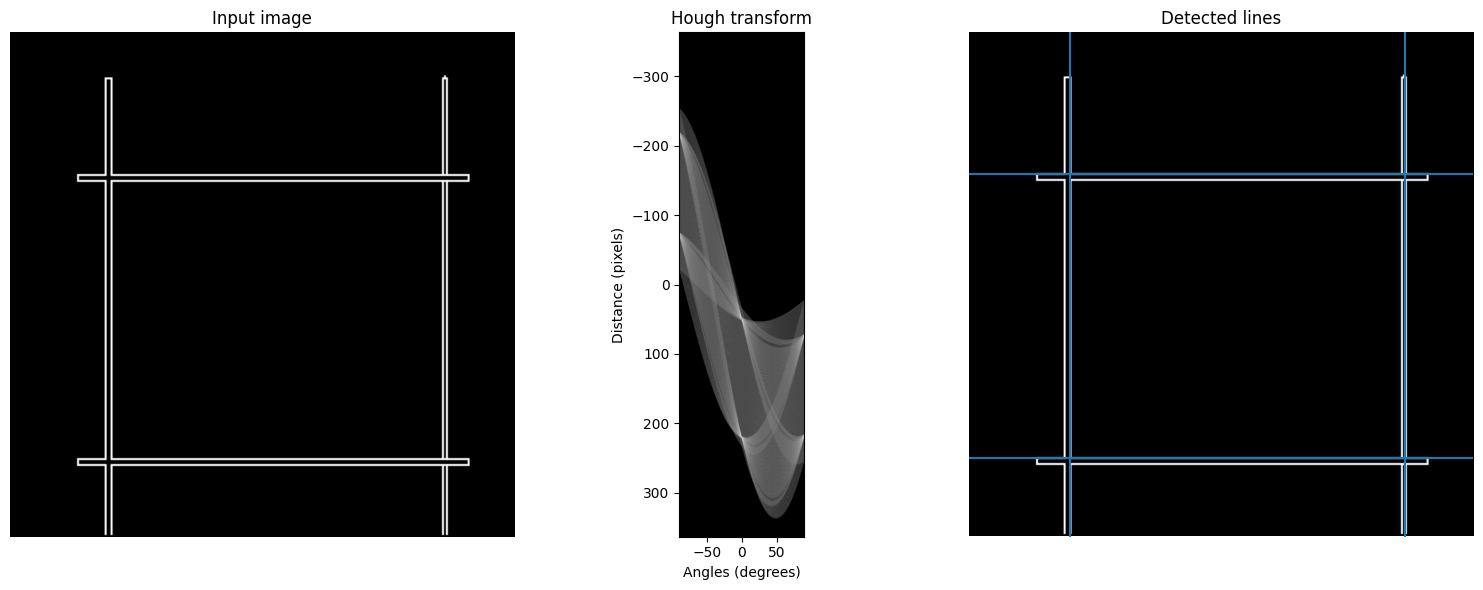

[(221.0, 72.0), (221.0, 216.0), (51.0, 72.0), (51.0, 216.0)]
72 216
51 221


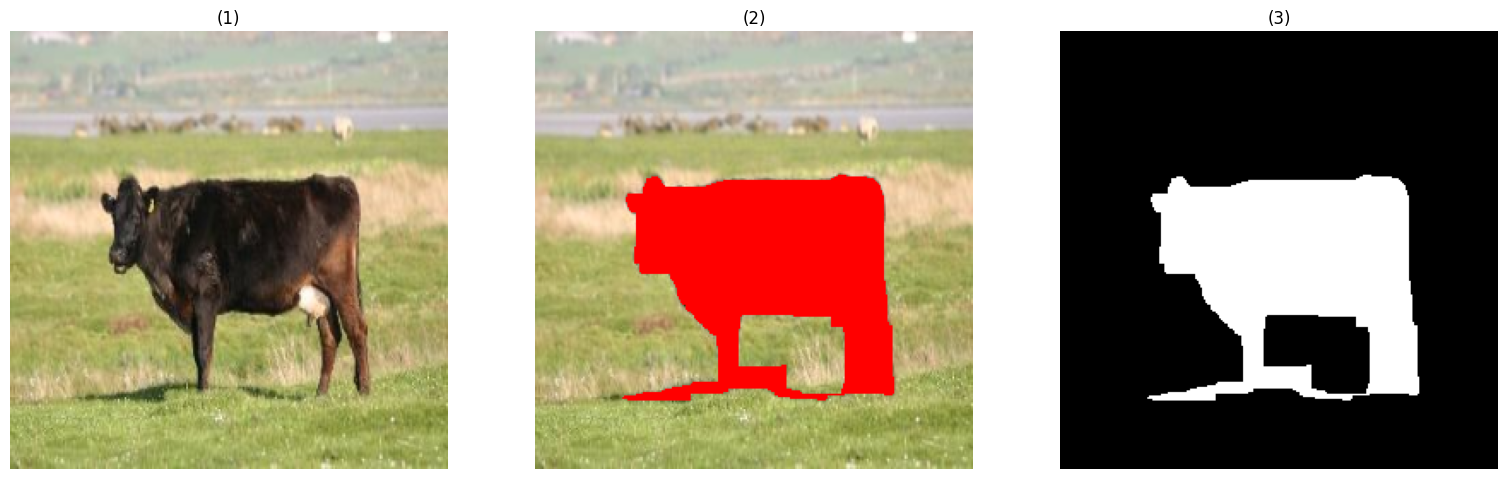

In [186]:
cow_select=io.imread('images-to-be-tested/cow_with_selection.png')
cow_orig=io.imread('images-to-be-tested/cow.jpg')

target_img_size = (256, 256)

cow_sel_resize = cv2.resize(cow_select, target_img_size)
cow_sel_conversion = rgba2rgb(cow_sel_resize)
cow_resized_orig = cv2.resize(cow_orig, target_img_size)


# # Create an instance of the RegionDetection class
region_detector_1 = RegionDetection(cow_resized_orig, cow_sel_conversion)
region_mask, binary_mask_test=region_detector_1.get_mask_by_region_detection()

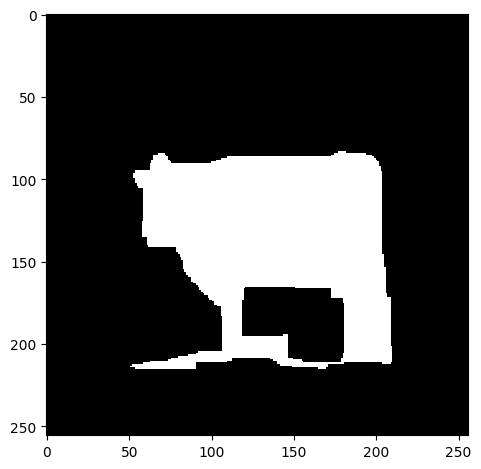

In [187]:
io.imshow(binary_mask_test)

In [188]:
def MSD(target_patch, exemplar_patch, M_bar):
    # if not np.isin(1,M_bar):
    #     return float('inf')
    if np.sum(M_bar)==0:
        return float('inf')
    else:
     msd=np.sum((M_bar*target_patch - M_bar*exemplar_patch)**2)/np.sum(M_bar)
     return msd
    # return msd

    # msd=np.sum((M_bar*target_patch - M_bar*exemplar_patch)**2)

    

def SMD (target_patch, exemplar_patch, binary_mask, M_bar):
    # if not np.isin(1,M_bar):
    #     return float('inf')
    if np.sum(M_bar)==0:
        return float('inf')
    if np.sum(binary_mask)==0:
        return float('inf')
    target_existing_avg= np.sum(M_bar * target_patch)/np.sum(M_bar)
    exemplar_fill_avg = np.sum(binary_mask* exemplar_patch)/np.sum(binary_mask)
    smd= (target_existing_avg-exemplar_fill_avg)**2
    return smd 

    # target_existing_avg= np.sum(M_bar * target_patch)
    # exemplar_fill_avg = np.sum(binary_mask* exemplar_patch)
    # smd= (target_existing_avg-exemplar_fill_avg)**2
    # return smd 

def findBestsubPatch(target_patch, exemplar_patches, binary_mask, M_bar):
    best_patch = exemplar_patches[len(exemplar_patches) // 2]
    min_combined_error = float('inf')

    for other_patch in exemplar_patches:
        current_error = MSD(target_patch, other_patch, M_bar) + SMD(target_patch, other_patch, binary_mask, M_bar)
        # print(f"Current Error: {current_error}")

        if current_error < min_combined_error:
            best_patch = other_patch
            min_combined_error = current_error

    return best_patch


def findBestFullPatch(target_patches, exemplar_patches,binary_mask_patches, M_bar_patches):
    cp_target_patches = np.copy(target_patches)
    for i,target_patch in enumerate(target_patches):
        best_sub_patch=findBestsubPatch(target_patch,exemplar_patches,binary_mask_patches[i],M_bar_patches[i])
        cp_target_patches[i][binary_mask_patches[i] == 1] = best_sub_patch[binary_mask_patches[i] == 1]
    return cp_target_patches


In [189]:
def main(img,binary_mask, overlap=2):
    patch_size = 50
    img_in_patches= [img[i:i+patch_size,j:j+patch_size] for i in range(0,img.shape[0]-patch_size+1, overlap) for j in range(0,img.shape[1]-patch_size+1, overlap) ]
    full_binary_mask_patches = [binary_mask[i:i+patch_size,j:j+patch_size] for i in range(0,img.shape[0]-patch_size+1, overlap) for j in range(0,img.shape[1]-patch_size+1, overlap) ]
    #if the patch contains a single 1 then it's subset of the target patch so mark it with 1 in the bit map
    # bit_map=[ 1 if np.isin(1,full_binary_mask_patches[i]) else 0 for i in range(len(full_binary_mask_patches))]

    target_indices=[]
    exemplar_indices=[]
    binary_mask_patches= []
    target_patches=[]
    exemplar_patches=[]
    target_patch_counter=0
    patches_per_row = (img.shape[0] - patch_size) // overlap + 1
    patches_per_col = (img.shape[1] - patch_size) // overlap + 1
    for i, binary_mask_patch in enumerate(full_binary_mask_patches):

        start_row = (i // patches_per_row) * overlap
        start_col = (i % patches_per_row) * overlap
        if np.isin(1,binary_mask_patch):
            # This means that it is a target patch
            target_indices.append((target_patch_counter,start_row,start_col))
            binary_mask_patches.append(full_binary_mask_patches[i])
            target_patches.append(img_in_patches[i])
            target_patch_counter+=1
            # binary_mask_patches.append(binary_mask[start_row:start_row+patch_size])

        else:
            exemplar_indices.append((i, start_row, start_col))
            exemplar_patches.append(img_in_patches[i])


    # M_bar_patches=[np.where((binary_mask_patches[i]==0)|(binary_mask_patches[i]==1), binary_mask_patches[i]^1, binary_mask_patches) for i in range(len(binary_mask_patches))]
    M_bar_patches=[1-binary_mask_patches[i] for i in range(len(binary_mask_patches))]
    #TO-DO: call implemented functions
    new_target_patches=findBestFullPatch(target_patches,exemplar_patches,binary_mask_patches,M_bar_patches)
    print(len(new_target_patches))
    print(len(target_patches))
    print("new_target_patches",new_target_patches[0])
    print(new_target_patches[1])

    new_img= np.copy(img)
    for target_index, start_row, start_col in target_indices:
        print(target_index)
        new_img[start_row: start_row+patch_size, start_col:start_col+patch_size]=new_target_patches[target_index]
    
    return new_img

    # list of tuples (i,start_row,start_col)
    '''
    for target_index, start_row, start_col in target_indices:
        img[start_row:start_row+patch_size , start_col: start_col+patch_size]=cp_target_patches[target_index]
        start_row = (i // (img.shape[0] // patch_size)) * patch_size
        start_col = (i % (img.shape[1] // patch_size)) * patch_size
    
    '''




In [190]:
binary_mask_test=binary_mask_test[:,:,0]
grayLevelImg = (rgb2gray(cow_resized_orig)*255).astype('uint8')

16
16
new_target_patches [[182 187 193 ... 207 209 210]
 [176 182 182 ... 201 203 204]
 [173 177 167 ... 190 190 190]
 ...
 [179 180 173 ... 167 176 182]
 [184 184 172 ... 180 186 187]
 [191 190 184 ... 194 196 195]]
[[208 202 195 ... 203 203 203]
 [198 188 178 ... 200 201 200]
 [180 168 157 ... 201 202 198]
 ...
 [197 196 197 ... 167 176 182]
 [200 199 198 ... 180 186 187]
 [203 200 198 ... 194 196 195]]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


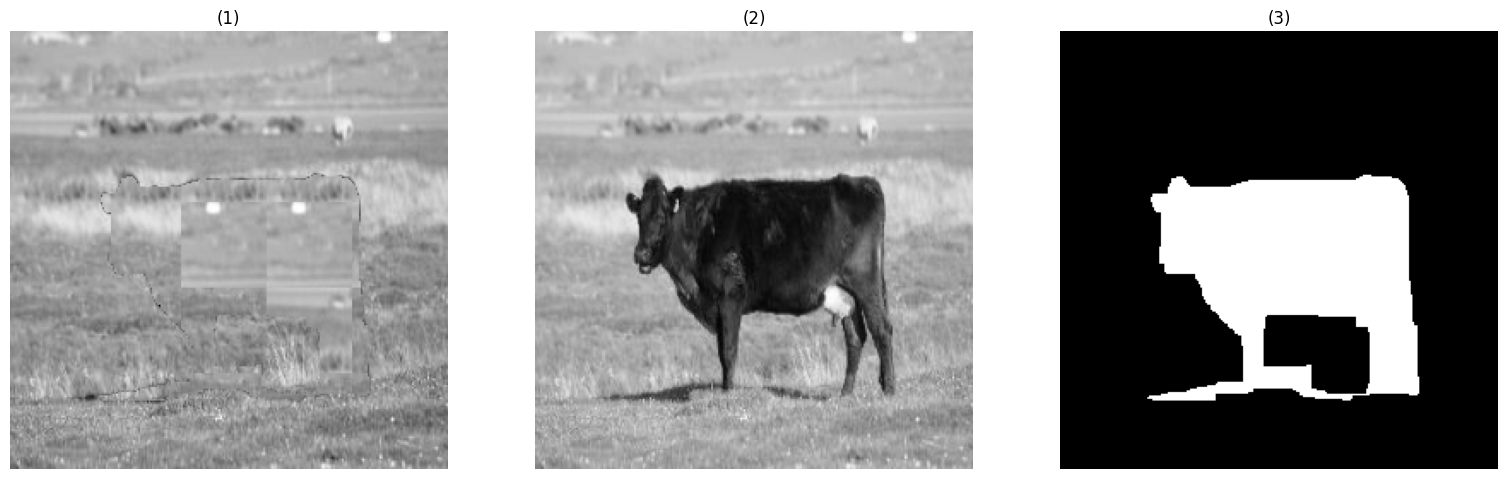

In [191]:

newImg= main(grayLevelImg,binary_mask_test, overlap=50)
show_images([newImg,grayLevelImg,   binary_mask_test])

2094
2094
new_target_patches [[184 179 173 ... 171 182 190]
 [192 181 171 ... 175 182 190]
 [197 185 174 ... 176 181 187]
 ...
 [185 189 189 ... 150 151 152]
 [187 188 188 ... 140 127 125]
 [185 185 185 ... 134 179 184]]
[[172 176 180 ... 198 189 175]
 [169 175 180 ... 198 193 180]
 [170 173 176 ... 194 191 183]
 ...
 [191 190 185 ... 169 194 208]
 [192 191 185 ... 133 165 197]
 [191 192 185 ... 181 129 174]]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
1

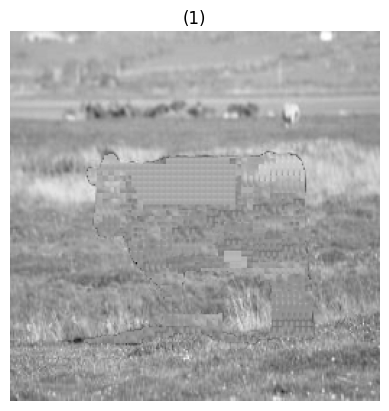

In [192]:
newImgOverlap2= main(grayLevelImg,binary_mask_test, overlap=4)
show_images([newImgOverlap2])

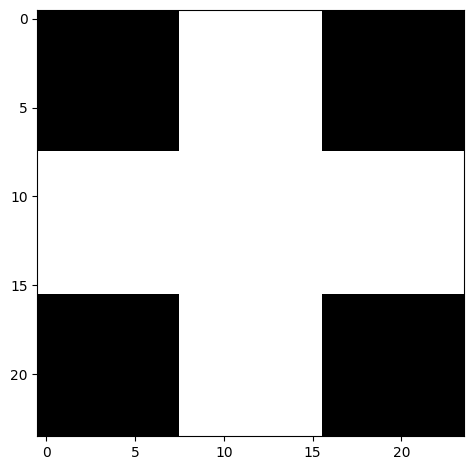

In [193]:
img1=np.zeros((24,24))
img1=np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],

    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],


    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],

])

img1=(img1*255).astype('uint8')
img1=255-img1
io.imshow(img1)

[[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1

C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


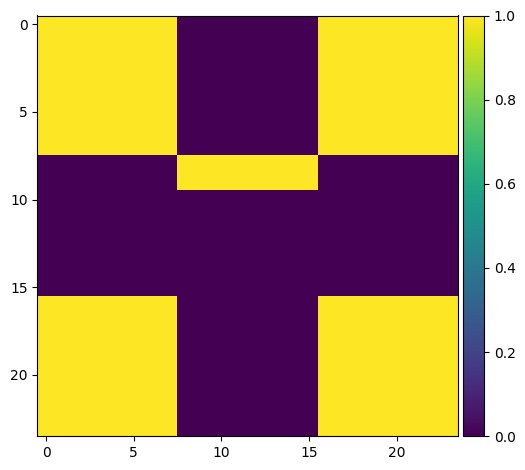

In [194]:
img2=np.copy(img1)
img2=(img2*255).astype('uint8')
print(img2)
img3=1-img2
img3[8:10,8:16]=1
print(img3)
io.imshow(img3)


binary_mask_img2=np.zeros((24,24))
binary_mask_img2[8:12,8:16]=1

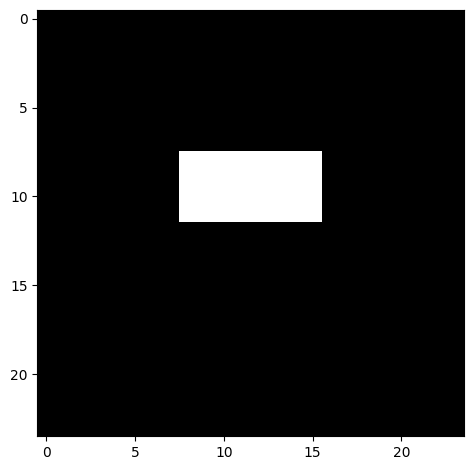

In [195]:
io.imshow(binary_mask_img2)

In [196]:
newImg2= main(img2,binary_mask_img2,overlap=8)
show_images([newImg2])

0
0


IndexError: index 0 is out of bounds for axis 0 with size 0